### Evaluation Hand Detection Pipeline

This scripts tests the hand detection and gesture classification models in conjunction.
The test setup has been set up exactly like the inference setup when controlling the JetBot. 
An input image of size 300 x 300 px is passed first to the detection model. 
The detection model detects hands in the image if there are any. 
Then the cutout is being resized to 64 x 64 px and passed on to the classification model. 
These hands are then classified as a gesture.

A confidence threshold has been defined for the hand detection model. The same threshold is used for inference in 
the demo case for controlling the JetBot.

All needed adjustments are marked with "Todo".

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# ToDo: Only necessary if you changed the selected gestures in the script data_preprocessing_lared.ipynb.
# adjust the names and quantity of the gestures here too.

INDEX_TO_LABEL = {
    0 :"crawl",
    1 :"fist",
    2 :"five",
    3 :"palm",
    4 :"peace",
}

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

NUMBER_OF_CLASSES = 5

# Todo: change path to the test directory wich contains uncorpped images
TEST_DIR_300x300 = "C:/datasets/lared/300x300/test"


THRESHOLD_HAND_DETECTION = 0.8

### Load data

In [3]:
def images_to_array(path):
    """ This method takes a path containing images in different folders representing the classes.
    Parameters:
        path (str): path to image folder
    Returns:
        Two arrays containing the images and corresponding labels
     """
    images = []
    labels = []

    curr_label = 0
    
    for dir_gesture in os.listdir(path):
        curr_dir = os.path.join(path, dir_gesture)
        curr_files = os.listdir(curr_dir)
        
        print(dir_gesture)
        
        for file in curr_files:
            img_path = os.path.join(curr_dir, file)
            image_as_array = cv2.imread(img_path)
            image_as_array = cv2.cvtColor(image_as_array, cv2.COLOR_BGR2RGB)

            images.append(image_as_array)
            labels.append(tf.keras.utils.to_categorical(curr_label,NUMBER_OF_CLASSES))
  
        curr_label = curr_label + 1
        
    return images, labels

test_images300x300, test_labels300x300 =  images_to_array(TEST_DIR_300x300)

print("image_data_format()", tf.keras.backend.image_data_format())
print("Test images      ",  len(test_images300x300), np.array(test_images300x300[0]).shape,  
      " Test labels ", len(test_labels300x300))

crawl
fist
five
palm
peace
image_data_format() channels_last
Test images       2850 (300, 300, 3)  Test labels  2850


### Load models

The detection and classification models are needed.

In [4]:
# hand detection model
model_dir = Path("../2_detection/model_ssd_mobilenetV2")
model_detect = tf.saved_model.load(str(model_dir))
model_detect = model_detect.signatures['serving_default']
print("hand detection model loaded")

# gesture classification model
model_dir = Path("../3_classification/model_mobilenet")
model_classify = tf.saved_model.load(str(model_dir))
print("gesture classification model loaded")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
hand detection model loaded
gesture classification model loaded


### Helper methods

In [5]:
def get_detected_hand_boxes(img):
    """ Takes in image of arbitrary size and returns bounding boxes along with confidence scores after detecting
    hands in the image.
    """
    input_tensor = tf.convert_to_tensor(img)
    input_tensor = input_tensor[tf.newaxis,...]
    
    hand_detections = model_detect(input_tensor)
    
    boxes, hand_scores = filter_detected_boxes(hand_detections, threshold=THRESHOLD_HAND_DETECTION)
    
    return boxes, hand_scores


def filter_detected_boxes(hand_detections, threshold):
    """ Filter the detected hands according to defined threshold.
    
    Only bounding boxes that have been detected above the threshold will be returned.
    Returns: 
        boxes: Bounding boxes of detected hands
        hand_scores: Probability that the detected object is a hand
    """
    boxes_raw = hand_detections['detection_boxes'].numpy()[0]
    scores = hand_detections['detection_scores'].numpy()[0]
    
    boxes = []
    hand_scores = []
    for i, score in enumerate(scores):
        if score > threshold:
            box = boxes_raw[i]
            
            ymin = int(float(box[0])*IMAGE_HEIGHT)
            xmin = int(float(box[1])*IMAGE_WIDTH)
            ymax = int(float(box[2])*IMAGE_HEIGHT)
            xmax = int(float(box[3])*IMAGE_WIDTH)

            score = round(score,2)
            hand_scores.append(score)
            
            boxes.append((xmin, ymin, xmax, ymax))
            
    return boxes, hand_scores


def add_boxes_to_img(img, boxes):
    """ Draw bounding boxes on an image
    
    The calculated probabilities for a hand detection or a gesture classification will be added to the image.
    The gesture names will be drawn on the image.    
    
    Input:
        img: Image that contains the bounding boxes
        boxes: The bounding boxes to draw
        hand_scores: The probability of a detected hand
        gesture_names: The names of classified gestures
        gesture_scores: The probability of a classified gesture
    Returns: 
        img: The input image with drawn bounding boxes and scores
    """
    
    for box in boxes:
        print(box)
        (xmin, ymin, xmax, ymax) = box

        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,205,205), 1)

    return img


def crop_rect(img, xmin, xmax, ymin, ymax):
    """ Crop the the rectangular image to a square
    
    Input:
        img: Image that contains the bounding box
        xmin, xmax, ymin, ymax: Coordinates of a hand bounding box
    Returns: 
        img: Input image cropped to a square
    """
    x, y = xmin, ymin
    w = xmax - xmin # width
    h = ymax - ymin # height
    
    # crop a square form
    if w > h:
        y = y - int((w-h)/2)
        h = w    
        #make sure y is within picture
        y = max(y,0)
        y = min(y, IMAGE_HEIGHT-h)

    elif h > w:
        x = x - int((h-w)/2)
        w = h
        #make sure x is within picture
        x = max(x,0)
        x = min(x,IMAGE_WIDTH-w)
        
    img = img[y:y+h, x:x+w]
    img = cv2.resize(img, (64,64))
        
    return img

### Test how many hands per image are detected

All input images contain exactly one hand. 
When running the detection model with the defined threshold of 0.8 one hand is not detected. In all other cases
exactly one hand is detected per image.

No hand in this image detected!


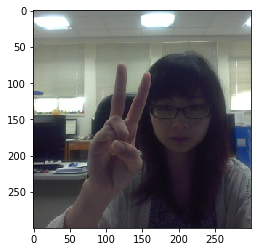

Total statistics for detected hands
Count images with no boxes detected:        1
Count images with exactly one box detected: 2849
Count images with two or more box detected: 0


In [6]:
count_no_box_detected = count_exactly_one_box_detected = count_2_and_more_boxes_detected = 0

for img in test_images300x300:   
    boxes, hand_scores = get_detected_hand_boxes(img)
    
    if len(boxes) == 0:
        count_no_box_detected += 1
        print("No hand in this image detected!")
        plt.imshow(img)
        plt.show()
    elif len(boxes) == 1:
        count_exactly_one_box_detected += 1
    else:
        count_2_and_more_boxes_detected += 1

print("Total statistics for detected hands")
print("Count images with no boxes detected:       ", count_no_box_detected)
print("Count images with exactly one box detected:", count_exactly_one_box_detected)
print("Count images with two or more box detected:", count_2_and_more_boxes_detected)
    

Print an arbitrary image along with the detected hand.

(10, 84, 189, 255)


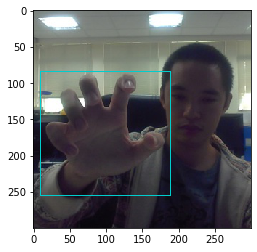

In [7]:
index = 200
img = test_images300x300[index]
boxes, hand_scores = get_detected_hand_boxes(img)
img = add_boxes_to_img(img, boxes)
plt.imshow(img)

### Test detection and classification pipeline combined

In [8]:
def classify_gesture(img):

    # preprocess image
    img = img/255
    img = img.astype('float32')
    input_tensor = tf.convert_to_tensor(img)
    input_tensor = input_tensor[tf.newaxis,...]

    # run classification model
    prediction = model_classify(input_tensor)

    # format prediction
    predicted_index = np.argmax(prediction, axis=1)[0]

    return predicted_index

Classify all detected hands.

The code below runs the detection model on each images cropping the hand and passing it on to the classification model.
When a hand is not detected a label -1 is assigned to the image instead of trying to classify it. 
The new label -1 "no gesture" is also used to generate the confusion matrix.

This metrics represent the accuracy of the whole detection and classification pipeline.

skipping image since no hand detected, label is set to -1


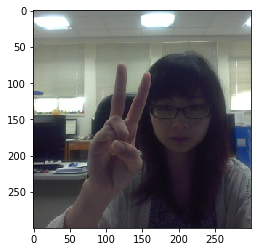

Confusion Matrix
[[  0   0   0   0   0   0]
 [  0 570   0   0   0   0]
 [  0   0 570   0   0   0]
 [  0   3   0 565   0   2]
 [  0   0   0   0 570   0]
 [  1   0   0   0   0 569]]

 Accuracy 0.9978947368421053

 Classification Report
              precision    recall  f1-score   support

  no gesture     0.0000    0.0000    0.0000         0
       crawl     0.9948    1.0000    0.9974       570
        fist     1.0000    1.0000    1.0000       570
        five     1.0000    0.9912    0.9956       570
        palm     1.0000    1.0000    1.0000       570
       peace     0.9965    0.9982    0.9974       570

    accuracy                         0.9979      2850
   macro avg     0.8319    0.8316    0.8317      2850
weighted avg     0.9983    0.9979    0.9981      2850



C:\Users\Dimitri\Anaconda3\envs\jetbot\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
labels = test_labels300x300
images_detected_hands = []  # the cropped images by the detection model are being saved to show detection errors later

y_pred = []
for img in test_images300x300:
    # detect hand
    boxes, _ = get_detected_hand_boxes(img)
    
    # only run classification model, when exactly one hand is detected
    if len(boxes) == 1:
        xmin, ymin, xmax, ymax = boxes[0]
        # crop detected hand
        img = crop_rect(img, xmin, xmax, ymin, ymax)

        # classify gesture
        y_pred.append(classify_gesture(img))
        
    # if not exactly one hand is detection, the classification is considered wrong
    else:
        print("skipping image since no hand detected, label is set to -1")
        plt.imshow(img)
        plt.show()
        y_pred.append(-1)
        
    images_detected_hands.append(img)
    
y_true = np.argmax(labels, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

print("\n Accuracy", accuracy_score(y_true, y_pred))

print('\n Classification Report')
target_names = ['no gesture', 'crawl','fist', 'five', 'palm', 'peace']    
        
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

### Show misclassified images

When looking at misclassified images its interesting to find out what the reason of the error is. 
Is it the wrongly cropped image or something else? For this reason the the classification test set is 
loaded here for comparison reasons. It contains the manually cropped images with the help of the mask. 
This allows to show the cropped images by the detection model and the manually cropped images side by side.

In [10]:
# Todo: change path to the test directory which contains manually cropped images, cropped with the help of mask files
# These images are being used only for comparison reasons
TEST_DIR_64x64 = "C:/datasets/lared/cropped_gesture64x64/test"

test_images64x64, test_labels64x64 =  images_to_array(TEST_DIR_64x64)

print("image_data_format()", tf.keras.backend.image_data_format())
print("Test images      ",len(test_images64x64),  np.array(test_images64x64[0]).shape,  
      " Test labels ", len(test_labels64x64))

crawl
fist
five
palm
peace
image_data_format() channels_last
Test images       2850 (64, 64, 3)  Test labels  2850
